In [1]:
import bayes3d as b
import jax.numpy as jnp
import jax
import os
import matplotlib.pyplot as plt
import jax.tree_util as jtu
from tqdm import tqdm
import json
import numpy as np
from scipy.spatial.transform import Rotation as R

Jupyter environment detected. Enabling Open3D WebVisualizer.
[Open3D INFO] WebRTC GUI backend enabled.
[Open3D INFO] WebRTCWindowSystem: HTTP handshake server disabled.


In [2]:
b.setup_visualizer()

You can open the visualizer by visiting the following URL:
http://127.0.0.1:7014/static/


In [4]:
data = json.load( open('trial_96.json'))
table_data = json.load(open('table_stats.json'))

In [ ]:
data["head_info"][100]

In [ ]:
# Outputs

# All positions on the table that the orange could be



In [5]:
def xyz_dict_to_array(xyz_dict):
    return jnp.array([xyz_dict["x"], xyz_dict["y"], xyz_dict["z"]])
    
def get_pose_from_aryan_dict(data):
    left_position = xyz_dict_to_array(data["position"])
    left_rotation = R.from_euler("xyz", np.array(xyz_dict_to_array(data["orientation"])),degrees=True).as_matrix()
    left_pose = b.transform_from_rot_and_pos(left_rotation, left_position)
    return left_pose

In [6]:
table_data
table_pose = b.transform_from_pos(xyz_dict_to_array(table_data["pos"]))
table_scale = xyz_dict_to_array(table_data["scale"])

In [16]:
left_pose = get_pose_from_aryan_dict(data["objs_info"]["left"])
left_scale = xyz_dict_to_array(data["objs_info"]["left"]["scale"])
right_pose = get_pose_from_aryan_dict(data["objs_info"]["right"])
right_scale = xyz_dict_to_array(data["objs_info"]["right"]["scale"])

print(left_pose)
print(right_pose)
print(left_scale, right_scale)

camera_offset = b.transform_from_axis_angle(jnp.array([0.0, 0.0, 1.0]), jnp.pi)
camera_poses = jnp.array([get_pose_from_aryan_dict(d) @ camera_offset for d in data["head_info"]])
print(camera_poses)

[[ 1.          0.          0.         -0.21589041]
 [ 0.          1.          0.          1.0262454 ]
 [ 0.          0.          1.          0.25      ]
 [ 0.          0.          0.          1.        ]]
[[-1.0000000e+00  0.0000000e+00  1.2246469e-16  2.4317198e-01]
 [ 0.0000000e+00  1.0000000e+00  0.0000000e+00  1.0262454e+00]
 [-1.2246469e-16  0.0000000e+00 -1.0000000e+00  2.4993148e-01]
 [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]
[0.85 2.2  0.08] [1.05 2.2  0.08]
[[[-9.9999887e-01  1.3803721e-03 -6.4199069e-04  0.0000000e+00]
  [-1.3786094e-03 -9.9999529e-01 -2.7379515e-03  1.5920370e+00]
  [-6.4576708e-04 -2.7370632e-03  9.9999607e-01 -4.0000001e-01]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000e+00]]

 [[-9.9999887e-01  1.3670156e-03 -6.4203388e-04  5.4258853e-05]
  [-1.3652587e-03 -9.9999535e-01 -2.7290795e-03  1.5927780e+00]
  [-6.4576155e-04 -2.7281998e-03  9.9999607e-01 -4.0043533e-01]
  [ 0.0000000e+00  0.0000000e+00  0.0000000e+00  1.0000000

In [8]:
b.RENDERER = None
intrinsics = b.Intrinsics(
    height=100,
    width=100,
    fx=100.0, fy=100.0,
    cx=50.0, cy=50.0,
    near=0.01, far=50.0
)

b.setup_renderer(intrinsics)


b.RENDERER.add_mesh_from_file("dining_room_table.obj", scaling_factor=table_scale, center_mesh=False)
b.RENDERER.add_mesh_from_file("shoebox_fused.obj", scaling_factor=left_scale, center_mesh=False)
b.RENDERER.add_mesh_from_file("shoebox_fused.obj", scaling_factor=right_scale, center_mesh=False)

[E rasterize_gl.cpp:121] OpenGL version reported as 4.6


Increasing frame buffer size to (width, height, depth) = (128, 128, 1024)


In [17]:
b.clear()
b.show_trimesh("table", b.RENDERER.meshes[0])
b.set_pose("table", table_pose)

b.show_trimesh("left", b.RENDERER.meshes[1])
b.set_pose("left", left_pose)

b.show_trimesh("right", b.RENDERER.meshes[2])
b.set_pose("right", right_pose)

for i in range(len(camera_poses)):
    b.show_pose(f"head_{i}", camera_poses[i])

In [15]:
table_dims, bbox_offset_pose = b.utils.aabb(b.RENDERER.meshes[0].vertices)
table_plane = table_pose @ bbox_offset_pose @ b.scene_graph.get_contact_planes(table_dims)[0]
b.show_pose("plane", table_plane)

In [22]:
grid = b.utils.make_translation_grid_enumeration_3d(
    -table_dims[0]/2, -table_dims[1]/2, -0.0,
    table_dims[0]/2, table_dims[1]/2, 0.0,
    50,50,1
)
relative_pose_from_edge_vmap = jax.jit(jax.vmap(b.scene_graph.relative_pose_from_edge, in_axes=(0, None, None)))
orange_poses = table_plane @ relative_pose_from_edge_vmap(grid, 0, b.RENDERER.model_box_dims[2])

# for (i,p) in enumerate(orange_poses):
#     b.show_pose(f"orange_{i}", p)

In [8]:
def get_poses(ids, *args):
    full_ids = jnp.concatenate([jnp.array([0]), ids])
    root_poses = jnp.tile(table_pose[None,...], (ids.shape[0] + 1, 1,1))
    return full_ids, b.scene_graph.poses_from_scene_graph(
        root_poses,
        b.RENDERER.model_box_dims[full_ids],
        jnp.concatenate([jnp.array([-1]), jnp.full(ids.shape, 0)]),
        jnp.stack([jnp.zeros((3,)), *args]),
        jnp.full(full_ids.shape, 0),
        jnp.full(full_ids.shape, 1),
    )
get_poses_jit = jax.jit(get_poses)
get_poses_parallel = jax.jit(jax.vmap(
    get_poses,
    in_axes=(None, None, None, 0)
))

def render_depth(ids, *contact_params):
    full_ids, poses = get_poses(ids, *contact_params)
    return b.RENDERER.render(poses, full_ids)[:,:,:3]
render_depth_jit = jax.jit(render_depth)

def score_scene(observed_image, ids, variance, outlier_prob, *contact_params):
    rendered = render_depth(ids, *contact_params)
    return b.threedp3_likelihood(observed_image, rendered, variance, outlier_prob, OUTLIER_VOLUME, 1)
score_scene_jit = jax.jit(score_scene)

def viz_trace(ids, *contact_params):
    all_ids, poses = get_poses_jit(ids, *contact_params)
    colors = b.viz.distinct_colors(max(10, len(all_ids)))
    b.clear()
    for (i,(id,p)) in enumerate(zip(all_ids, poses)):
        b.show_trimesh(f"obj_{i}", b.RENDERER.meshes[id],color=colors[i])
        b.set_pose(f"obj_{i}", p)

    depth = render_depth_jit(ids, *contact_params)
    b.show_cloud("depth", depth[:,:,:3].reshape(-1,3))

parallel_scorer = jax.jit(jax.vmap(
    score_scene,
    in_axes=(None, None, None, None, None, None, 0)
))

contact_bounds = jnp.array([jnp.array([-2.5, -2.5, -2*jnp.pi]), jnp.array([2.5, 2.5, 2*jnp.pi])]),

19764.809


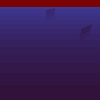

In [26]:
N = 2
gt_ids = jnp.array([1, 1])
key = jax.random.PRNGKey(10)
gt_contact_params = (jnp.array([0.0, 1.0, jnp.pi/3]), jnp.array([1.0, 0.0, jnp.pi/3]))
observed_image = render_depth_jit(gt_ids, *gt_contact_params)
viz_trace(gt_ids, *gt_contact_params)
score = score_scene(observed_image, gt_ids, 0.0001, 0.0001, *gt_contact_params)
print(score)
b.get_depth_image(observed_image[:,:,2])

In [17]:
bounds = 1.5
grid = b.utils.make_translation_grid_enumeration_3d(
    -bounds, -bounds, -0.0,
    bounds, bounds, 0.0,
    50,50,1
)

In [19]:
%%time
ids = jnp.array([1, 1, 2])
scores = parallel_scorer(observed_image, ids, 0.0001, 0.0001, *gt_contact_params, grid)
print(scores.min(), scores.max())

19454.14 19768.008
CPU times: user 76.5 ms, sys: 49.6 ms, total: 126 ms
Wall time: 123 ms


In [14]:
sampled_indices = jax.random.categorical(key, scores, shape=(100,))
sampled_poses = get_poses_parallel(ids, *gt_contact_params, grid[sampled_indices])[1][:,-1,...]

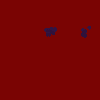

In [15]:
img = b.RENDERER.render(sampled_poses, jnp.full(sampled_poses.shape[0], 2))
b.get_depth_image(img[:,:,2])

In [16]:
viz_trace(gt_ids, *gt_contact_params)
final_id = ids[-1]
for (i,p) in enumerate(sampled_poses):
    b.show_trimesh(f"target_obj_{i}", b.RENDERER.meshes[final_id])
    b.set_pose(f"target_obj_{i}", p)

In [ ]:
# 

In [21]:
b.clear()